In [ ]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

# Load dữ liệu
df = pd.read_csv('/gdrive/MyDrive/CDTN3/heart.csv')
df

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
0        0   0     1       1  
1        0   0     2       1  
2        2   0     2       1  
3        2   0     2       1  
4        2   0     2       1  
..     ...  ..   ...     ...  
298      1   0     3       0  
299      1   0     3       0  
300      1   2     3       0  
301      1   1     3       0  
302      1   1     2       0  

[303 rows x 14 columns]

* age: Tuổi của bệnh nhân (numeric).
* sex: Giới tính của bệnh nhân (0 = nữ, 1 = nam).
* cp (chest pain type): Loại cơn đau ngực (categorical):
0: Đau ngực điển hình (typical angina).
1: Đau ngực không điển hình (atypical angina).
2: Đau ngực không phải do bệnh mạch vành (non-anginal pain).
3: Không có triệu chứng (asymptomatic pain).
* trestbps: Huyết áp nghỉ (systolic blood pressure at rest, numeric).
* chol: Mức độ cholesterol trong máu (serum cholesterol, numeric).
* fbs (fasting blood sugar): Đường huyết lúc đói (categorical):
0: Đường huyết thấp hơn 120 mg/dl.
1: Đường huyết lớn hơn hoặc bằng 120 mg/dl.
* restecg (resting electrocardiographic results): Kết quả điện tâm đồ lúc nghỉ ngơi (categorical):
0: Bình thường.
1: Có sóng ST-T không bình thường (sóng T có thể bị đảo ngược).
2: Có dấu hiệu của phì đại thất trái (LVH) theo điện tâm đồ.
* thalach: Nhịp tim cao nhất khi tập luyện (maximum heart rate achieved, numeric).
* exang (exercise induced angina): Cơn đau thắt ngực do tập thể dục (categorical):
0: Không có cơn đau thắt ngực khi tập thể dục.
1: Có cơn đau thắt ngực khi tập thể dục.
* oldpeak: Sự giảm ST khi gắng sức (numeric): Đo độ dốc của đoạn ST (sự thay đổi sóng ST) so với lúc nghỉ ngơi.
* slope: Dốc của đoạn ST trong khi tập thể dục (categorical):
0: Dốc lên (upsloping).
1: Dốc phẳng (flat).
2: Dốc xuống (downsloping).
* ca: Số lượng mạch vành bị tắc nghẽn (numeric): Khoảng từ 0 đến 4.
* thal: Loại bệnh thalassemia (categorical):
1: Thalassemia bình thường (normal).
2: Thalassemia cố định (fixed defect).
3: Thalassemia có thể hồi phục (reversible defect).
* target: Kết quả phân loại (categorical):
0: Không bị bệnh tim.
1: Có bệnh tim.

In [ ]:
# Kiểm tra thông tin cơ bản
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None


In [ ]:
# Kiểm tra giá trị bị thiếu và trùng lặp
print(f"Số giá trị bị thiếu: {df.isnull().sum().sum()}")
duplicate_count = df.duplicated().sum()
print(f"Số bản ghi trùng lặp: {duplicate_count}")
# Loại bỏ các bản ghi trùng lặp
if duplicate_count > 0:
    df = df.drop_duplicates()
    print("Đã loại bỏ các bản ghi trùng lặp.")
# Kiểm tra phân phối của cột mục tiêu
print("Phân phối của target:")
print(df['target'].value_counts())

Số giá trị bị thiếu: 0
Số bản ghi trùng lặp: 1
Đã loại bỏ các bản ghi trùng lặp.
Phân phối của target:
target
1    164
0    138
Name: count, dtype: int64


* Biến liên tục: age, chol, trestbps, thalach, oldpeak

* Biến nhị phân: sex , fbs, exang chỉ nhận hai giá trị (0 hoặc 1)

In [ ]:
# Biến các thuộc tính phân loại thành dạng one hot
a = pd.get_dummies(df['cp'], prefix="cp")
b = pd.get_dummies(df['thal'], prefix="thal")
c = pd.get_dummies(df['slope'], prefix="slope")

frames = [df, a, b, c]
df = pd.concat(frames, axis=1)

# Bỏ các thuộc tính cũ đi
df = df.drop(columns=['cp', 'thal', 'thal_0', 'slope'])

# Đổi tên các loại theo tên gọi
df = df.rename(columns={'cp_0': 'typical_angina_pain',
                        'cp_1': 'atypical_angina_pain',
                        'cp_2': 'non-anginal_pain',
                        'cp_3': 'asymptomatic_pain',
                        'slope_0': 'upsloping_st',
                        'slope_1': 'flat_st',
                        'slope_2': 'downsloping_st',
                        'thal_1': 'thalassemia_normal',
                        'thal_2': 'thalassemia_fixed',
                        'thal_3': 'thalassemia_reversable'})
df

age  sex  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  ca  ...  \
0     63    1       145   233    1        0      150      0      2.3   0  ...   
1     37    1       130   250    0        1      187      0      3.5   0  ...   
2     41    0       130   204    0        0      172      0      1.4   0  ...   
3     56    1       120   236    0        1      178      0      0.8   0  ...   
4     57    0       120   354    0        1      163      1      0.6   0  ...   
..   ...  ...       ...   ...  ...      ...      ...    ...      ...  ..  ...   
298   57    0       140   241    0        1      123      1      0.2   0  ...   
299   45    1       110   264    0        1      132      0      1.2   0  ...   
300   68    1       144   193    1        1      141      0      3.4   2  ...   
301   57    1       130   131    0        1      115      1      1.2   1  ...   
302   57    0       130   236    0        0      174      0      0.0   1  ...   

     typical_angina_pain  atypical_angina_pain  non-anginal_pain  \
0                  False                 False             False   
1                  False                 False              True   
2                  False                  True             False   
3                  False                  True             False   
4                   True                 False             False   
..                   ...                   ...               ...   
298                 True                 False             False   
299                False                 False             False   
300                 True                 False             False   
301                 True                 False             False   
302                False                  True             False   

     asymptomatic_pain  thalassemia_normal  thalassemia_fixed  \
0                 True                True              False   
1                False               False               True   
2                False               False               True   
3                False               False               True   
4                False               False               True   
..                 ...                 ...                ...   
298              False               False              False   
299               True               False              False   
300              False               False              False   
301              False               False              False   
302              False               False               True   

     thalassemia_reversable  upsloping_st  flat_st  downsloping_st  
0                     False          True    False           False  
1                     False          True    False           False  
2                     False         False    False            True  
3                     False         False    False            True  
4                     False         False    False            True  
..                      ...           ...      ...             ...  
298                    True         False     True           False  
299                    True         False     True           False  
300                    True         False     True           False  
301                    True         False     True           False  
302                   False         False     True           False  

[302 rows x 21 columns]

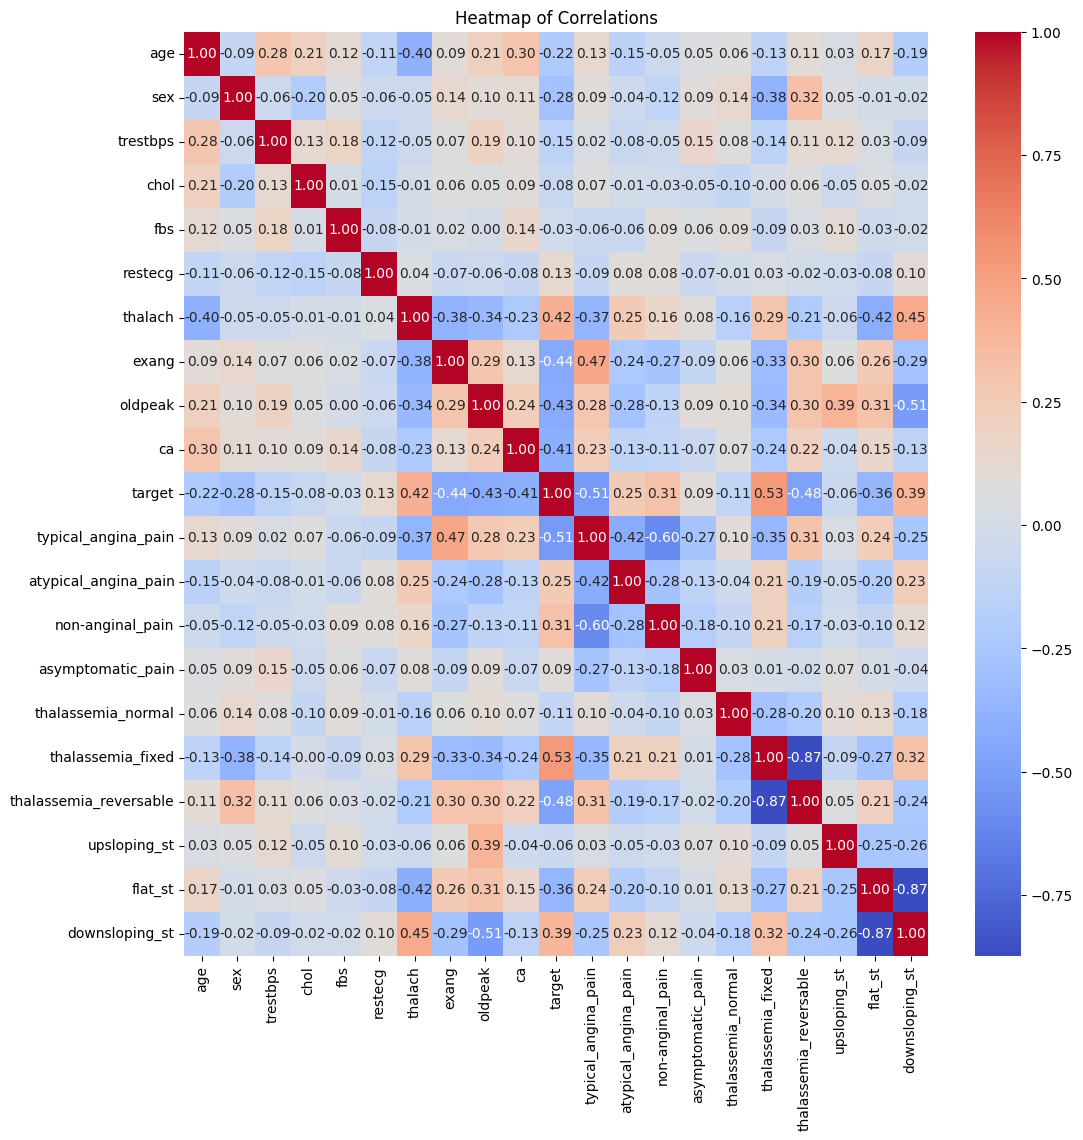

In [ ]:
# Hiển thị ma trận tương quan
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Heatmap of Correlations")
plt.show()

In [ ]:
# Tách dữ liệu thành X (đặc trưng) và y (nhãn)
x_data = df.drop(['target'], axis=1)
y = df['target']

In [ ]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(x_data), columns=x_data.columns)

In [ ]:
# Tách dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Lưu tập test để sử dụng sau
X_test.to_csv('/gdrive/MyDrive/CDTN3/X_test.csv', index=False)
y_test.to_csv('/gdrive/MyDrive/CDTN3/y_test.csv', index=False)
print("Tập test đã được lưu thành công.")

Tập test đã được lưu thành công.


Mô hình GaussianNB đã được lưu thành công.


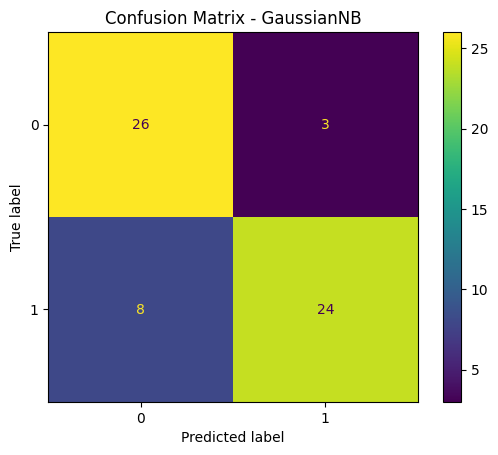

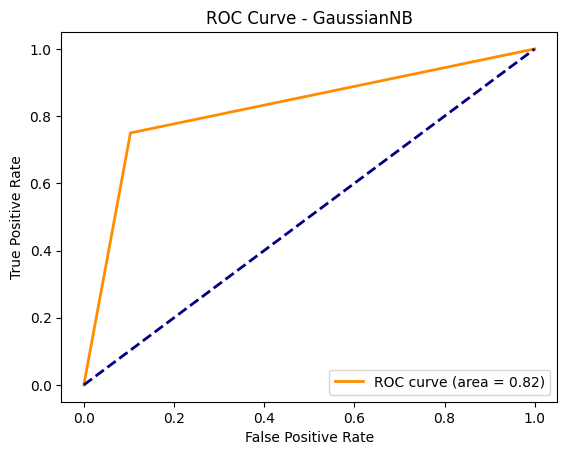

In [ ]:
# Khởi tạo và huấn luyện Gaussian Naive Bayes
model_gaussian = GaussianNB()
model_gaussian.fit(X_train, y_train)

# Lưu mô hình đã huấn luyện
pickle.dump(model_gaussian, open('/gdrive/MyDrive/CDTN3/GaussianNB_model.pkl', 'wb'))
print("Mô hình GaussianNB đã được lưu thành công.")

# Dự đoán và đánh giá GaussianNB
predict_test_gaussian = model_gaussian.predict(X_test)
gaussiannb_accuracy = accuracy_score(y_test, predict_test_gaussian)
gaussiannb_recall = recall_score(y_test, predict_test_gaussian, average='weighted')
gaussiannb_precision = precision_score(y_test, predict_test_gaussian, average='weighted')
gaussiannb_f1 = f1_score(y_test, predict_test_gaussian, average='weighted')

# Confusion Matrix for GaussianNB
cm_gaussian = confusion_matrix(y_test, predict_test_gaussian)
disp_gaussian = ConfusionMatrixDisplay(confusion_matrix=cm_gaussian, display_labels=model_gaussian.classes_)
disp_gaussian.plot()
plt.title("Confusion Matrix - GaussianNB")
plt.show()

# ROC Curve for GaussianNB
fpr_gaussian, tpr_gaussian, _ = roc_curve(y_test, predict_test_gaussian)
roc_auc_gaussian = auc(fpr_gaussian, tpr_gaussian)
plt.figure()
plt.plot(fpr_gaussian, tpr_gaussian, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc_gaussian:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GaussianNB')
plt.legend(loc="lower right")
plt.show()

Mô hình BernoulliNB đã được lưu thành công.


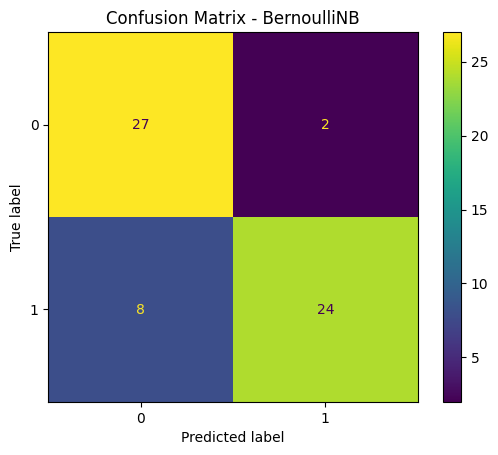

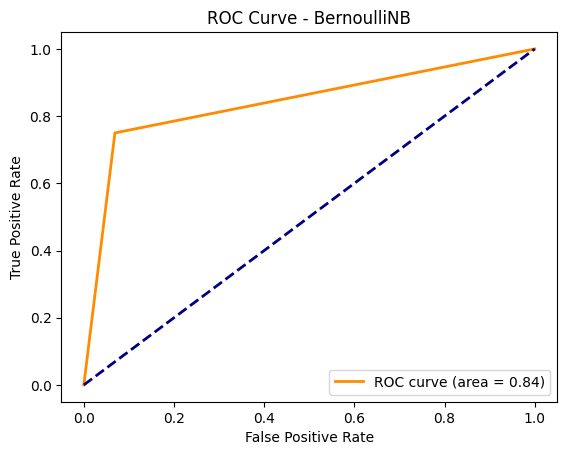

In [ ]:
# Khởi tạo và huấn luyện Bernoulli Naive Bayes
model_bernoulli = BernoulliNB()
model_bernoulli.fit(X_train, y_train)

# Lưu mô hình BernoulliNB
pickle.dump(model_bernoulli, open('/gdrive/MyDrive/CDTN3/BernoulliNB_model.pkl', 'wb'))
print("Mô hình BernoulliNB đã được lưu thành công.")

# Dự đoán và đánh giá BernoulliNB
predict_test_bernoulli = model_bernoulli.predict(X_test)
bernoullinb_accuracy = accuracy_score(y_test, predict_test_bernoulli)
bernoullinb_recall = recall_score(y_test, predict_test_bernoulli, average='weighted')
bernoullinb_precision = precision_score(y_test, predict_test_bernoulli, average='weighted')
bernoullinb_f1 = f1_score(y_test, predict_test_bernoulli, average='weighted')

# Confusion Matrix for BernoulliNB
cm_bernoulli = confusion_matrix(y_test, predict_test_bernoulli)
disp_bernoulli = ConfusionMatrixDisplay(confusion_matrix=cm_bernoulli, display_labels=model_bernoulli.classes_)
disp_bernoulli.plot()
plt.title("Confusion Matrix - BernoulliNB")
plt.show()
# ROC Curve for BernoulliNB
fpr_bernoulli, tpr_bernoulli, _ = roc_curve(y_test, predict_test_bernoulli)
roc_auc_bernoulli = auc(fpr_bernoulli, tpr_bernoulli)

# Plot ROC Curve
plt.figure()
plt.plot(fpr_bernoulli, tpr_bernoulli, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc_bernoulli:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BernoulliNB')
plt.legend(loc="lower right")
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:52:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mô hình XGBoost đã được lưu thành công.


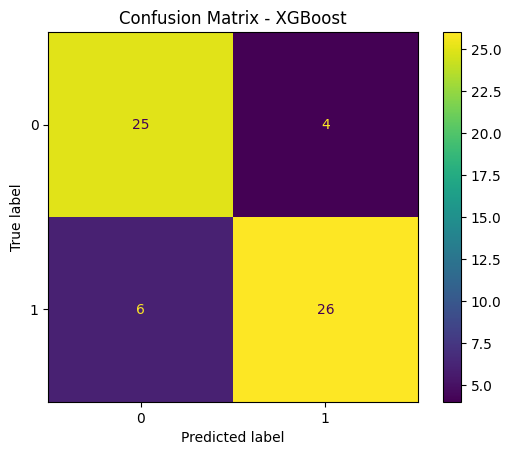

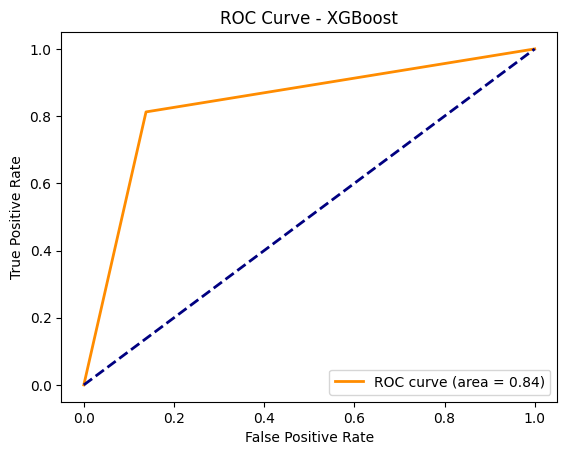

In [ ]:
# Khởi tạo và huấn luyện XGBoost
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)

# Lưu mô hình XGBoost
pickle.dump(model_xgb, open('/gdrive/MyDrive/CDTN3/XGB_model.pkl', 'wb'))
print("Mô hình XGBoost đã được lưu thành công.")

# Dự đoán và đánh giá XGBoost
predict_test_xgb = model_xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, predict_test_xgb)
xgb_recall = recall_score(y_test, predict_test_xgb, average='weighted')
xgb_precision = precision_score(y_test, predict_test_xgb, average='weighted')
xgb_f1 = f1_score(y_test, predict_test_xgb, average='weighted')

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, predict_test_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=model_xgb.classes_)
disp_xgb.plot()
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, predict_test_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Tổng hợp kết quả
results = {
    "Model": ["GaussianNB", "BernoulliNB", "XGBoost"],
    "Accuracy": [gaussiannb_accuracy, bernoullinb_accuracy, xgb_accuracy],
    "Recall": [gaussiannb_recall, bernoullinb_recall, xgb_recall],
    "Precision": [gaussiannb_precision, bernoullinb_precision, xgb_precision],
    "F1 Score": [gaussiannb_f1, bernoullinb_f1, xgb_f1]
}
results_df = pd.DataFrame(results)
print(results_df.to_markdown(index=False))


| Model       |   Accuracy |   Recall |   Precision |   F1 Score |
|:------------|-----------:|---------:|------------:|-----------:|
| GaussianNB  |   0.819672 | 0.819672 |    0.829851 |   0.819187 |
| BernoulliNB |   0.836066 | 0.836066 |    0.850982 |   0.835271 |
| XGBoost     |   0.836066 | 0.836066 |    0.83804  |   0.836154 |
